In [2]:
!pip install flair
import pandas as pd
import zipfile
from flair.data import Sentence, Corpus
from sklearn.model_selection import train_test_split
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
import torch
from torch.optim.lr_scheduler import OneCycleLR
from flair.trainers import ModelTrainer
import torch
from flair.models import TextClassifier
from flair.embeddings import TransformerDocumentEmbeddings
from torch.optim.adam import Adam
from flair.embeddings import TransformerWordEmbeddings




     |████████████████████████████████| 286kB 11.1MB/s 
     |████████████████████████████████| 2.1MB 9.8MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2MB 37.8MB/s 
     |████████████████████████████████| 798kB 42.4MB/s 
     |████████████████████████████████| 983kB 38.7MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 19.7MB 50.3MB/s 
     |████████████████████████████████| 901kB 39.0MB/s 
     |████████████████████████████████| 3.3MB 35.6MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9693 sha256=f70420e72ce824049bcbedae85cb70865436720617c72b0abeab822da17c730a
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Created wheel for sqlitedict: fil

--2021-04-30 14:41:09--  https://github.com/untruenews/ss2021/raw/main/data/data.csv.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/untruenews/ss2021/main/data/data.csv.zip [following]
--2021-04-30 14:41:10--  https://raw.githubusercontent.com/untruenews/ss2021/main/data/data.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85485669 (82M) [application/zip]
Saving to: ‘data.csv.zip.1’

data.csv.zip.1      100%[===================>]  81.53M   158MB/s    in 0.5s    

2021-04-30 14:41:10 (158 MB/s) - ‘data.csv.zip.1’ saved [85485669/85485669]



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[]

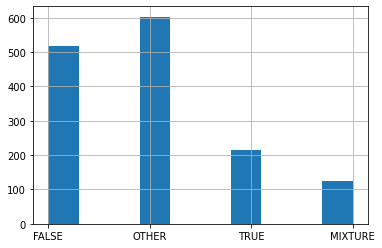

In [12]:
#opening the data
!wget https://github.com/untruenews/ss2021/raw/main/data/data.csv.zip
zf = zipfile.ZipFile("data.csv.zip") 

#zf = zipfile.ZipFile("../data/data.csv.zip") 
df_raw = pd.read_csv(zf.open('data_out.csv')).sample(n=2000, random_state=1)
df_raw["rating_alternateName_normalized"]=df_raw["rating_alternateName_normalized"].str.upper() #only making sure the labels are normalized.

##taking only thet english data.
df_english=df_raw[df_raw.language=="en"][["claimReview_claimReviewed","rating_alternateName_normalized"]]
df_english.rating_alternateName_normalized.hist().plot()

In [13]:
#splint the data
X=df_english["claimReview_claimReviewed"]
y=df_english["rating_alternateName_normalized"]
X_train, X_test, y_train, y_test = train_test_split(list(X), list(y), test_size=0.3, random_state=32)


##creating the corpus
train = [Sentence(X_train[i]).add_label("class",y_train[i]) for i in range(len(X_train))]
dev = [Sentence(X_test[i]).add_label("class",y_test[i]) for i in range(len(X_test))]
test = [Sentence(X_test[i]).add_label("class",y_test[i]) for i in range(len(X_test))]


'FALSE'

In [15]:
#https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

# 1. get the corpus
corpus: Corpus = Corpus(train, dev, test)

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

# 4. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)


# 5. initialize trainer
trainer: ModelTrainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# 6. start training
trainer.train('models/classifier',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=32,
              embeddings_storage_mode='gpu',
              max_epochs=5, # terminate after 5 epochs
              )


2021-04-30 14:41:56,384 Computing label dictionary. Progress:


100%|██████████| 1461/1461 [00:00<00:00, 32629.11it/s]

2021-04-30 14:41:56,437 [b'FALSE', b'OTHER', b'TRUE', b'MIXTURE']


2021-04-30 14:42:00,111 ----------------------------------------------------------------------------------------------------
2021-04-30 14:42:00,119 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in

{'dev_loss_history': [0.4912070631980896,
  0.47172096371650696,
  0.5364872813224792,
  0.5611405372619629,
  0.6678236126899719],
 'dev_score_history': [0.0523, 0.4138, 0.4054, 0.4327, 0.4549],
 'test_score': 0.4549,
 'train_loss_history': [0.5329231154173613,
  0.4575237696990371,
  0.39214043226093054,
  0.2957606604322791,
  0.16198099730536342]}